🔹 1. Imports & Setup

In [50]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import src.impact_model as impact_model
reload(impact_model)

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.impact_model import apply_event_effects, build_event_indicator_matrix


🔹 2. Load Data

In [42]:
fi_df = pd.read_csv("../data/processed/enriched_fi_data.csv")
impact_links_df = pd.read_csv("../data/processed/enriched_impact_links.csv")

print(fi_df.shape, impact_links_df.shape)


(43, 34) (15, 35)


🔹 3. Extract Events

In [43]:
events_df = fi_df[fi_df["record_type"] == "event"].copy()
print(f"Number of events: {len(events_df)}")


Number of events: 10


🔹 4. Merge Events with Impact Links (Correct Join)

In [44]:
merged_df = events_df.merge(
    impact_links_df,
    how="left",
    left_on="record_id",
    right_on="parent_id",
    suffixes=("_event", "_link")
)

print("Merged shape:", merged_df.shape)


Merged shape: (16, 69)


🔹 5. Define Indicator Code

In [45]:
# indicator_code does NOT exist in impact_links → use related_indicator
merged_df["indicator_code"] = merged_df["related_indicator_link"]


🔹 6. Compute Effect Values

In [60]:
# Reload updated impact_model
from importlib import reload
import src.impact_model as impact_model

reload(impact_model)
from src.impact_model import apply_event_effects

effects_df = apply_event_effects(merged_df)
effects_df





,record_id_event,indicator_code,impact_magnitude,lag_months,effect_value
0,EVT_0001,ACC_OWNERSHIP,25.0,12.0,25.0
1,EVT_0001,USG_TELEBIRR_USERS,25.0,3.0,25.0
2,EVT_0001,USG_P2P_COUNT,25.0,6.0,25.0
3,EVT_0002,ACC_4G_COV,15.0,12.0,15.0
4,EVT_0002,AFF_DATA_INCOME,15.0,12.0,15.0
5,EVT_0003,USG_MPESA_USERS,25.0,3.0,25.0
6,EVT_0003,ACC_MM_ACCOUNT,15.0,6.0,15.0
7,EVT_0004,ACC_OWNERSHIP,15.0,24.0,15.0
8,EVT_0004,GEN_GAP_ACC,15.0,24.0,15.0
9,EVT_0005,AFF_DATA_INCOME,25.0,3.0,25.0


🔹 7. Build Event–Indicator Association Matrix

In [61]:
association_matrix = (
    effects_df
    .pivot_table(
        index="record_id_event",
        columns="indicator_code",
        values="effect_value",
        aggfunc="sum",
        fill_value=0
    )
)

association_matrix


indicator_code,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
record_id_event,,,,,,,,,
EVT_0001,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,25.0
EVT_0002,15.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
EVT_0003,0.0,15.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0
EVT_0004,0.0,0.0,15.0,0.0,15.0,0.0,0.0,0.0,0.0
EVT_0005,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0
EVT_0007,0.0,0.0,0.0,0.0,0.0,15.0,0.0,15.0,0.0
EVT_0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
EVT_0010,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


🔹 8. Save Output

In [62]:
os.makedirs("../models", exist_ok=True)
association_matrix.to_csv("../models/impact_association_matrix.csv")


🔹 9. Heatmap Visualization

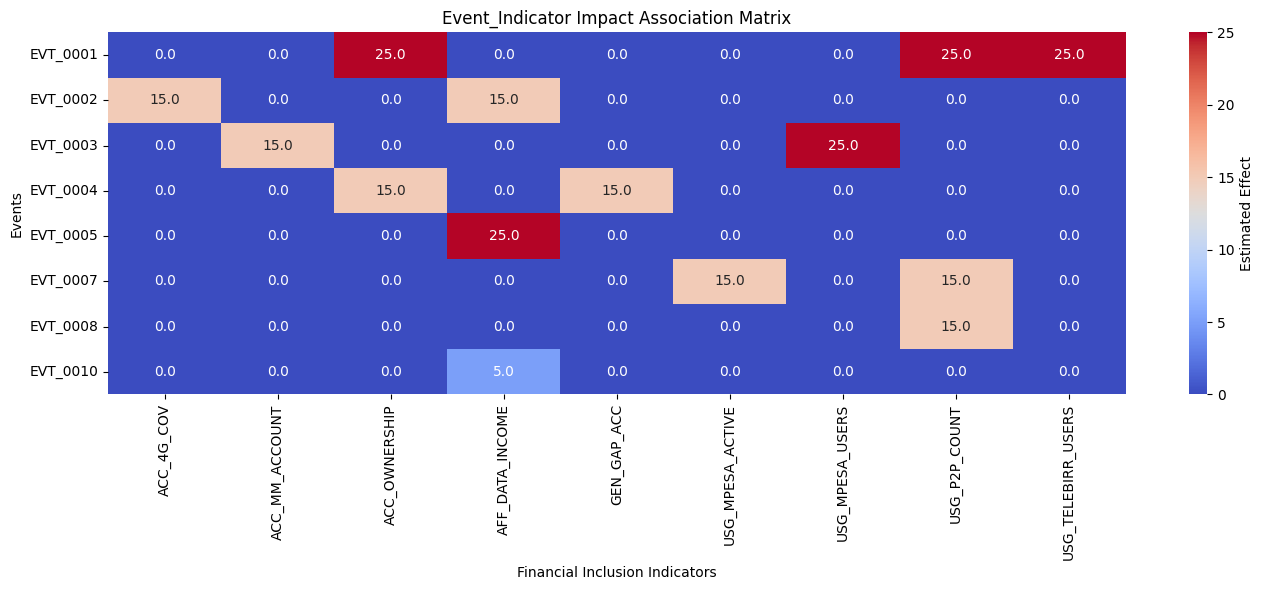

In [ ]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    association_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Estimated Effect"}
)
plt.title("Event-Indicator Impact Association Matrix")
plt.xlabel("Financial Inclusion Indicators")
plt.ylabel("Events")
plt.tight_layout()
plt.show()


# 10. Document methodology (Markdown)
# -------------------------
# Use Markdown cells in the notebook to document:
# - How effects were computed (considering direction)
# - Assumptions: linear effect, immediate application, cumulative for multiple events
# - Limitations: effect estimates may be uncertain for events without Ethiopian pre/post data
# - Validation results comparing predicted vs observed